In [2]:
%load_ext tensorboard

In [3]:
%matplotlib inline


import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import glob
import scipy.io
import copy
import datetime 
import time

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torchsummary import summary

import src.functions as fn


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('this computation is running on {}'.format(device))
device_name = str(device)[:3]



this computation is running on cuda:0


following: https://www.tensorflow.org/text/tutorials/text_generation

In [5]:
# open ascii txt:
filename = "romantische_lieder_hermannhesse.txt"
text_corpus = open(filename, 'r', encoding='utf-8').read()

raw_text = text_corpus
print('text has %i characters before cleaning'%len(raw_text))
vocab = sorted(set(raw_text))
char_to_int = dict((c, i) for i, c in enumerate(vocab))
print('len vocab: ',len(vocab))
print('\nvocabulary before cleaning:\n'+str(vocab))
char_counting = dict((c,raw_text.count(c)) for i,c in enumerate(vocab))
print('char_counting: ',char_counting)


text has 33440 characters before cleaning
len vocab:  72

vocabulary before cleaning:
['\n', ' ', '!', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '«', '»', 'Ä', 'Ö', 'Ü', 'ß', 'ä', 'ö', 'ü']
char_counting:  {'\n': 1444, ' ': 6872, '!': 61, "'": 87, '(': 3, ')': 3, ',': 423, '-': 133, '.': 320, ':': 9, ';': 21, '?': 20, 'A': 96, 'B': 88, 'C': 3, 'D': 311, 'E': 79, 'F': 88, 'G': 89, 'H': 152, 'I': 129, 'J': 19, 'K': 70, 'L': 115, 'M': 137, 'N': 58, 'O': 12, 'P': 30, 'Q': 2, 'R': 47, 'S': 222, 'T': 89, 'U': 155, 'V': 47, 'W': 149, 'Z': 30, '^': 12, 'a': 1085, 'b': 362, 'c': 814, 'd': 1086, 'e': 3634, 'f': 225, 'g': 520, 'h': 1126, 'i': 1880, 'j': 17, 'k': 268, 'l': 873, 'm': 781, 'n': 2754, 'o': 488, 'p': 93, 'q': 1, 'r': 1521, 's': 100

## Data cleansing/ editing

In [6]:
# how many poems in text?
# string that separated poems
sep_string = '\n\n\n\n\n'
nr_poems = text_corpus.count(sep_string)
print('number of poems = ',nr_poems)

# before counting the stanzas we have to get rid of the subtitles of some stanzas
# luckily they are numbered:
# I don't know why, but only got rid of I., II., ... numberation when I replaced the following:
sub_numberation = ['I.', 'II.', 'III.', 'IV.', 'V.', 'VI.','I\n\n', 'II\n\n', 'III\n\n', 'IV\n\n', 'V\n\n', 'VI\n\n', 'I\n\n']

sub_poems = 0
for sub in sub_numberation:
    if sub=='I.':
        print('how many poems have subpoems = ', str(text_corpus.count(sub)))
    sub_poems += text_corpus.count(sub)
print('number of subpoems =' , sub_poems)

# data cleansing: replace unnecessary characters and line breaks
# (in prediction too much linebreaks after each other leads to linebreak as prediction)
stanza = copy.copy(text_corpus)

for num in sub_numberation:
    stanza = stanza.replace(num, "\n")
    
end_sentence_char = ['_',':', '$', '*', '/','(',')', "'", '-', '^', '»', '«']
for char in end_sentence_char:
    stanza = stanza.replace(char, "")
    
# delete citization from text:
zitat_in = 'Ich habe den Fuß an jene Stelle des Lebens gesetzt,'
zitat_out = 'Dante'
inso = stanza.find(zitat_in)
outso = stanza.find(zitat_out)
stanza = stanza.replace(stanza[inso:outso+6], '')

stanza = stanza.replace('\n\n\n\n','\n')
stanza = stanza.replace('\n\n\n','\n')

# correction of some subtitle in order to match poemtitle - poem schematic
stanza = stanza.replace('Villalilla.\n', 'Villalilla.')
stanza = stanza.replace('Berceuse.\n\n', '\nBerceuse.\n')
stanza = stanza.replace('Grande valse.\n\n', 'Grande valse.\n')
stanza = stanza.replace('Du aber.\n\n', '\nDu aber.\n')
stanza = stanza.replace('Ich fragte Dich.\n\n', '\nIch fragte Dich.\n')
stanza = stanza.replace('Wenn doch mein Leben \n\n', '\nWenn doch mein Leben.\n')
stanza = stanza.replace('So ziehen Sterne \n\n', '\nSo ziehen Sterne.\n')
stanza = stanza.replace('So schön bist Du!\n\n', 'So schön bist Du!\n')
print('number of character after cleansing = ', len(stanza))
raw_text = stanza

number of poems =  45
how many poems have subpoems =  12
number of subpoems = 24
number of character after cleansing =  32663


## Text Prediction:

In [7]:
def mulitnomial_prediction(seed, model, temperature=0.4, predict_len=500):
    lstm = model.eval()
    initial_str = seed
    #### word generator: from https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Projects/text_generation_babynames/generating_names.py 19.01.22
    hidden = lstm.init_state(1)
    
    initial_input = fn.text_to_torch(initial_str, raw_text).long()
    predicted = initial_str

    # predicted hidden state for first characters
    for p in range(len(initial_str)-1):
        _, hidden = lstm(initial_input[p].to(device), hidden)
        
    last_char = initial_input[-1]
    for p in range(predict_len):
        output, hidden = lstm(last_char.to(device), hidden)
        output_dist = output.view(-1).div(temperature).exp()
        top_char = torch.multinomial(output_dist, 1)[0]

        predicted_char = fn.torch_to_text(top_char.cpu(), raw_text)[0]
        predicted += predicted_char
        last_char = fn.text_to_torch(predicted_char, raw_text).long()[0]

    return predicted

In [8]:
log_dir = 'logs'
writer = SummaryWriter(log_dir)
layer = [1,2,4]
hid = [1024,[512,256],[512,256,128,64]]

  0%|          | 0/70 [00:00<?, ?it/s]

Leben auscheres Herze Tapre,
   Wir wollten und Weg aus der Stadt vom Morgen und lauschen und allein
   Weg in der Hand
   Und am Brücke mein Heimwehland herbarg
   In meiner Freunde Tag verrrin langer Prinkgeld mir geht
   Versteckte Du mannt ein Blutbuche kallein!

   Zum Brun
   Mein Herz fällt die Zeit schönes Leben Haupt 
     Und daß Du mir?

Mansine Verstecken
   Steht der aus Deiner tragen
   Und schmal aufern
   Auf die sein tragen
   Und schen aus.

   Wir weißen sein Ster alle schlafen gangen
   Und dächhen,
   Mein Ämplein renen Mauern,
   Sommer fremden Mai  Ich hasse hören.

   Schmetterlitten
   Eine Lichtern schöner Frauern
   Wenn mein Lieder stolz dunkler Aberglittend mich bin Deiner Maus
   Und schmal auch nach Dein!

Weit aum Brund weichtet,
   Zugvög verschen Takönnen
   Wie lauter Schlummert das Fannigin,
   Und laß von mir der Traum ging der Haar
   Ween dorte Bänder!
     Senkern sagen der Stadt aus der Hand
   Ob empe Jüchsen!
   Wie damals,    Und der der Nach

  0%|          | 0/70 [00:00<?, ?it/s]

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

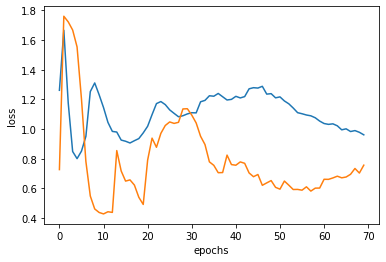

In [18]:
bat = [5,10,100,500]
for batch_size in bat:
    # Parameter settings

    #batch_size= 50 
    seq_len = 100
    hidden_size = 512
    num_embeddings = 256
    learning_rate = 0.003
    epochs = 70
    dropout = 0.2
    gru_layer = 1



    # loading data and model
    dataX,dataY,n_vocab = fn.tokenize(raw_text, seq_len=seq_len, target_is_sequence=True)
    data_loader = fn.pytorch_dataloader(dataX,dataY, n_vocab, seq_len, batch_size=batch_size)
    # model initiation
    gru = fn.Model(vocab_size=n_vocab, num_embeddings = num_embeddings, 
            hidden_size=hidden_size,lstm_layers=gru_layer).to(device)
    # model training
    train = fn.training(train_data=data_loader, epochs=epochs, 
        batch_size= batch_size, learning_rate=learning_rate, model=gru)
    # saving model

    name_prefix = 'models/project_data/gru%iseqlen%i_'%(gru_layer, seq_len)
    fn.save_model(save=True, train=train, device_name=device_name, 
                   hidden_size=hidden_size, batch_size=batch_size, 
                   epochs=epochs, learning_rate=learning_rate, 
                   num_embeddings=num_embeddings, seq_len=seq_len, dropout=dropout, name_prefix=name_prefix)

    save_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
    data_save = 'data/grubatch'+save_time+'%iseqlen%ihs%ib%iepoch%i'%(gru_layer, seq_len, hidden_size, batch_size, epochs)
    np.save(data_save, train[2])

    temp = [0.5, 0.8, 0.9]
    for t in temp:
        seed = 'Leben'
        temperature=t
        test = mulitnomial_prediction(seed, model=gru, temperature=temperature, predict_len=1000)


        print(test)
        text_save = 'data/txtbatch'+save_time+'%iseqlen%ihs%ib%iepoch%itemperature%i.txt'%(gru_layer, 
                                                                                             seq_len, hidden_size, 
                                                                                             batch_size, epochs, 
                                                                                             temperature*100)
        text_file = open(text_save, "w")
        n = text_file.write('#seed:'+seed+'\n\n'+test)
        text_file.close()
    print(text_save)

In [10]:
print(text_save)

data/txtprediction20220205_1846542seqlen140hs512b20epoch70temperature90.txt


In [20]:

seed = 'Leben'
temperature=0.5
test = mulitnomial_prediction(seed, model=gru, temperature=temperature, predict_len=1000)


print(test)
text_save = 'data/txtprediction'+save_time+'%iseqlen%ihs%ib%iepoch%itemperature%i.txt'%(gru_layer, 
                                                                                         seq_len, hidden_size, 
                                                                                         batch_size, epochs, 
                                                                                         temperature*100)
text_file = open(text_save, "w")
n = text_file.write('#seed:'+seed+'\n\n'+test)
text_file.close()

Leben.

   Ich   Dein Dich Dich bekleit verlorend.

   Die Nacht Die Körank
   Die Nachte lang und Hause
   Vergloßen Herzsen schauen
   Mein Händern keine Selken
   Mein Haupt und spurpurt geglanken Schloß.   In das Hand,
   Die Händer helmen Liebe
   Mein Herz schön er steht der Sollen Sein Spiehen
   In meine Trauf weiß in der Spielen spüren
   In liege träumen Haupt!

   De Herz das Hal im Geseg in Dein Hügel!
   Die Haupt spät.

Aen den Mädern flogen mit Kranz zu schwingsjert ein Hiel reiten,
   Ich weißen Schloß steht die Nächte lächte liegen,
   Denn kann zu jeden Neichten.

   Von meiner Herz mich aller Plaud und schwer,
   Von mill im Bann kommes Lieder mein Hand.

   Du weißen Mädchen Dir noch er über Schauert geht.

   Der schauen Leben,
   Mir so ling im Blücken allein.

   Ich weißen gring nie stumm und stehnen,
   Den allen Nächtertrten träg vergrerweichtern, schwandern gehen alleinen Flogen,
   Daren und Haupt!
   Den Kin ich Dir Dich war kann die ein Mäder ling nach Dir